In [38]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn import svm

In [2]:
df_games = pd.read_csv("appstore_games.csv")

# Data Cleaning

In [3]:
# Dropping unneeded columns
df_games.drop(labels=["URL","ID","Subtitle","Description","Languages","Primary Genre",
                      "Original Release Date","Current Version Release Date"], axis=1, inplace=True)

In [4]:
# Replacing null values in "User Rating Count" with a value of 0
df_games["User Rating Count"].fillna(value=0, inplace=True)

In [5]:
# Change in-app purchase column to be 0 (does not have in app purchases) or 1 (does have in app purchases)
df_games["In-app Purchases"].fillna(value=0, inplace=True)
df_games["In-app Purchases"].loc[df_games["In-app Purchases"] != 0] = 1

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
# Getting rid of + signs in "Age Rating" column
df_games.loc[df_games["Age Rating"] == "4+",["Age Rating"]] = "4"
df_games.loc[df_games["Age Rating"] == "9+",["Age Rating"]] = "9"
df_games.loc[df_games["Age Rating"] == "12+",["Age Rating"]] = "12"
df_games.loc[df_games["Age Rating"] == "17+",["Age Rating"]] = "17"

In [7]:
# Final cleaned dataframe
df_games = df_games.dropna()

In [8]:
df_games

,Name,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Developer,Age Rating,Size,Genres
0,Sudoku,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,4.0,3553.0,2.99,0,Mighty Mighty Good Games,4,15853568.0,"Games, Strategy, Puzzle"
1,Reversi,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,3.5,284.0,1.99,0,Kiss The Machine,4,12328960.0,"Games, Strategy, Board"
2,Morocco,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.0,8376.0,0.00,0,Bayou Games,4,674816.0,"Games, Board, Strategy"
3,Sudoku (Free),https://is3-ssl.mzstatic.com/image/thumb/Purpl...,3.5,190394.0,0.00,0,Mighty Mighty Good Games,4,21552128.0,"Games, Strategy, Puzzle"
4,Senet Deluxe,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,3.5,28.0,2.99,0,RoGame Software,4,34689024.0,"Games, Strategy, Board, Education"
...,...,...,...,...,...,...,...,...,...,...
16950,Die Last,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,3.0,6.0,0.00,0,Jie Yang,12,151308288.0,"Games, Strategy, Entertainment, Puzzle"
16956,Basic Slosh,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,5.0,30.0,0.00,0,Ashnell Marchand,4,79646720.0,"Games, Entertainment, Action, Strategy"
16962,Idle Racing Tycoon,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,5.0,51.0,0.00,0,Carson Brody,9,125348864.0,"Games, Simulation, Strategy"
16967,Glow Hockey Strike,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,5.0,5.0,0.00,0,Samir Jabeur,4,128687104.0,"Games, Simulation, Strategy"


# K-Means

In [9]:
def plotCurrent(X, Rnk, Kmus):
    N, D = np.shape(X)
    K = np.shape(Kmus)[0]

    InitColorMat = np.matrix([[1, 0, 0], 
                              [0, 1, 0],   
                              [0, 0, 1],
                              [0, 0, 0],
                              [1, 1, 0], 
                              [1, 0, 1], 
                              [0, 1, 1]])

    KColorMat = InitColorMat[0:K]
    colorVec = Rnk.dot(KColorMat)
    muColorVec = np.eye(K).dot(KColorMat)

    plt.scatter(X[:,0], X[:,1], edgecolors=colorVec, marker='o', facecolors='none', alpha=0.3)
    plt.scatter(Kmus[:,0], Kmus[:,1], c=muColorVec, marker='D', s=50);

In [10]:
def calcSqDistances(X, Kmus):
    return ((-2 * X.dot(Kmus.T) + np.sum(np.multiply(Kmus,Kmus), axis=1).T).T + np.sum(np.multiply(X,X), axis=1)).T

In [11]:
def determineRnk(sqDmat):
    m = np.argmin(sqDmat, axis=1)
    return np.eye(sqDmat.shape[1])[m]

In [12]:
def recalcMus(X, Rnk):
    return (np.divide(X.T.dot(Rnk), np.sum(Rnk, axis=0))).T

In [13]:
def runKMeans(K, data, subset):
    X = data[subset]
    
    N = len(X)
    D = 2
    
    X = X.to_numpy()
    X = X.astype(int)

    # Allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    # Initialize cluster centers by randomly picking points from the data
    rndinds = np.random.permutation(N)
    Kmus = X[rndinds[:K]];

    # Specify the maximum number of iterations to allow
    maxiters = 1000;

    for iter in range(maxiters):
        # Assign each data vector to closest mu vector as per Bishop (9.2)
        # Do this by first calculating a squared distance matrix where the n,k entry
        # contains the squared distance from the nth data vector to the kth mu vector

        # sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus);

        # given the matrix of squared distances, determine the closest cluster
        # center for each data vector 

        # R is the "responsibility" matrix
        # R will be an N-by-K matrix of binary values whose n,k entry is set 
        # Specifically, the n,k entry is 1 if point n is closest to cluster k,
        # and is 0 otherwise
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus
        plotCurrent(X, Rnk, Kmus)
        plt.show()

        # Recalculate mu values based on cluster assignments
        Kmus = recalcMus(X, Rnk)

        # Check to see if the cluster centers have converged.  If so, break.
        if sum(abs(KmusOld.flatten() - Kmus.flatten())) < 1e-6:
            break

    plotCurrent(X,Rnk,Kmus)

In [14]:
from sklearn.cluster import KMeans

# Calculates the Within-Cluster-Sum of Squared Erros in order to find the best K-value
def calculate_WSS(data, subset, kmax):
    points = data[subset]
    points = points.to_numpy()
    points = points.astype(int)
    sse = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0

        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
          curr_center = centroids[pred_clusters[i]]
          curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2

        sse.append(curr_sse)
    return sse

In [15]:
best_kvalue = calculate_WSS(df_games, ["Price", "Average User Rating"],10)

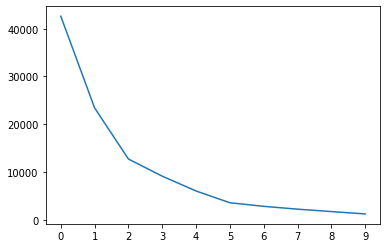

In [16]:
# Best K-value is at the "elbow" in the curve, in this case we choose 2
plt.xticks(np.arange(10))
plt.plot(best_kvalue)

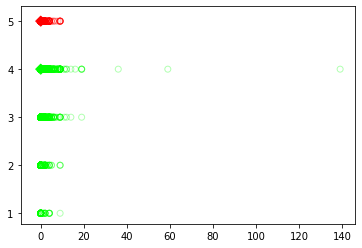

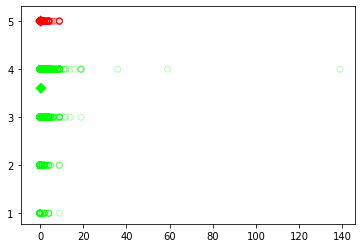

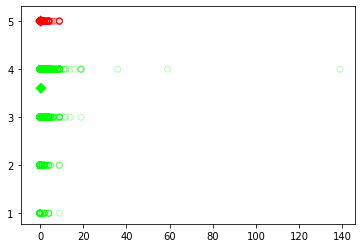

In [17]:
runKMeans(2, df_games, ["Price", "Average User Rating"])

In [18]:
best_kvalue = calculate_WSS(df_games, ["Size", "Average User Rating"],10)

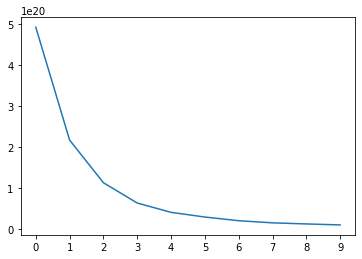

In [19]:
# Best K-value is at the "elbow" in the curve, in this case we choose 3
plt.xticks(np.arange(10))
plt.plot(best_kvalue)

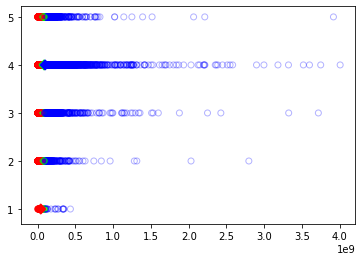

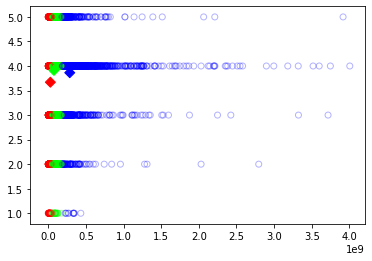

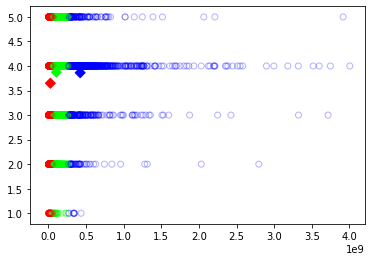

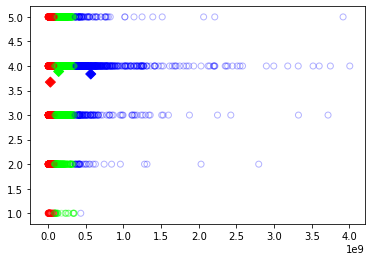

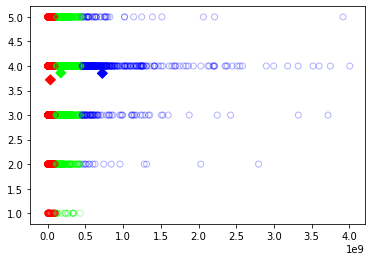

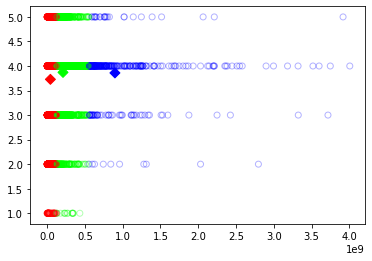

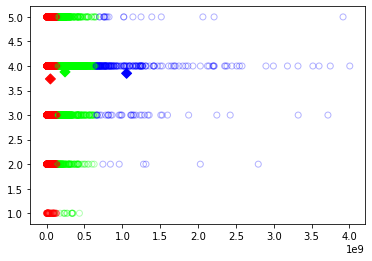

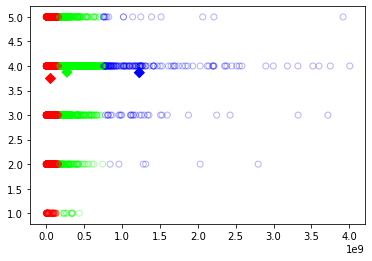

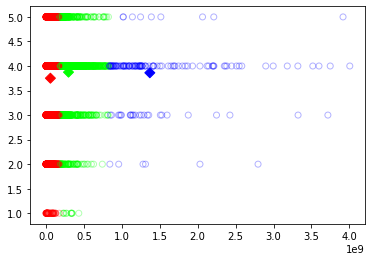

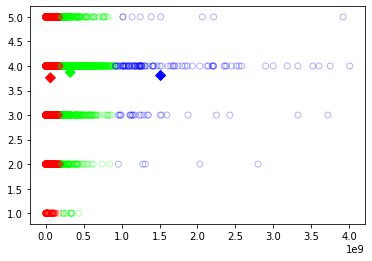

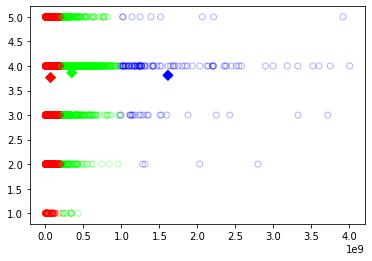

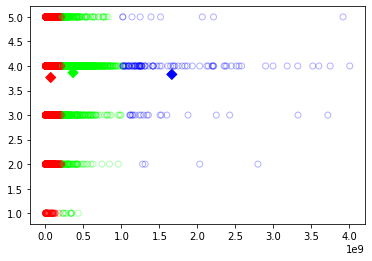

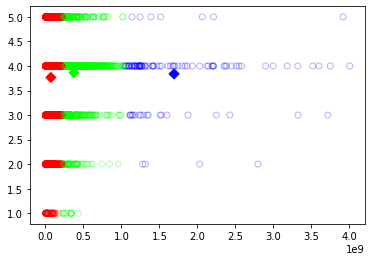

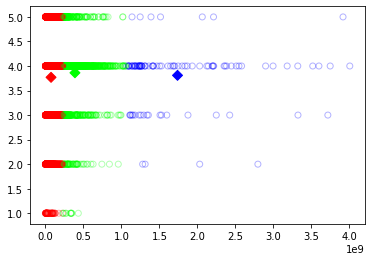

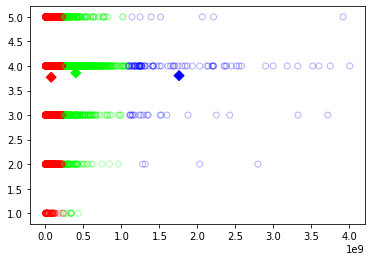

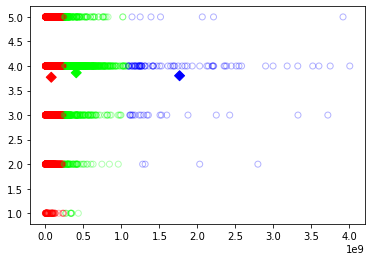

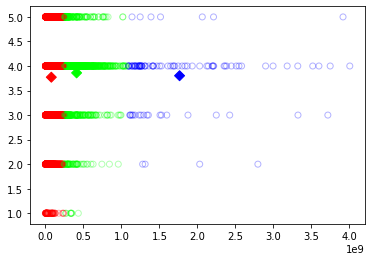

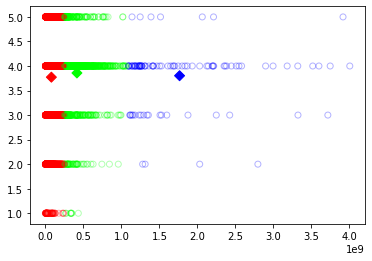

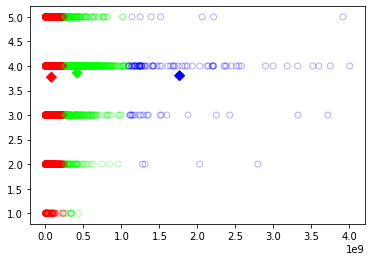

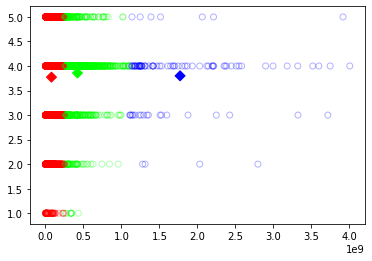

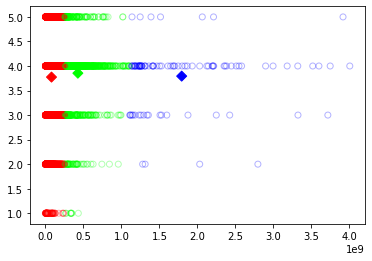

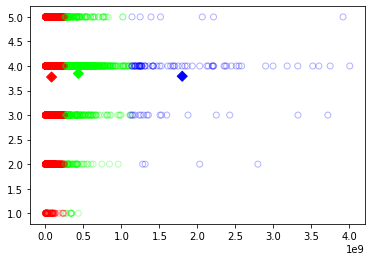

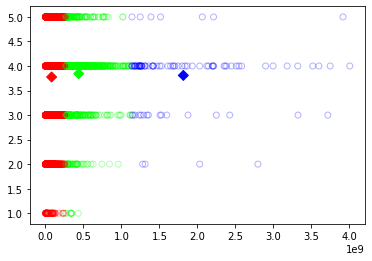

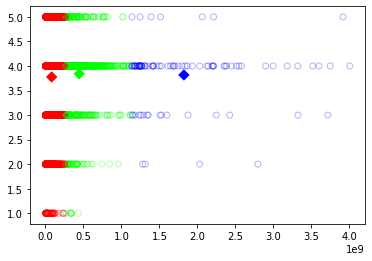

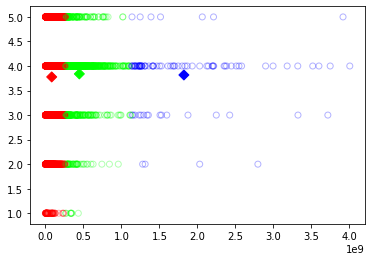

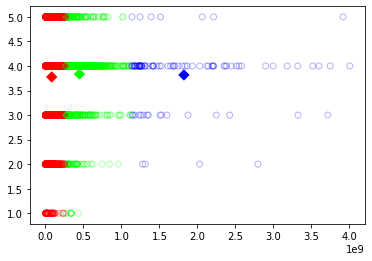

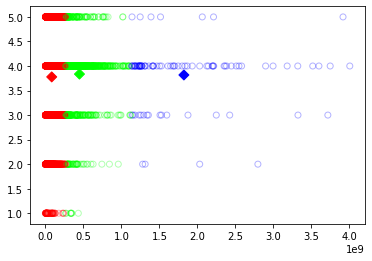

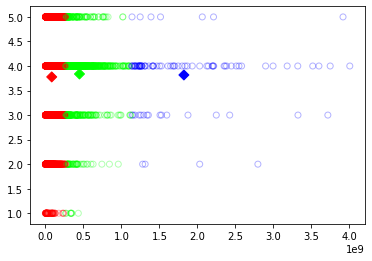

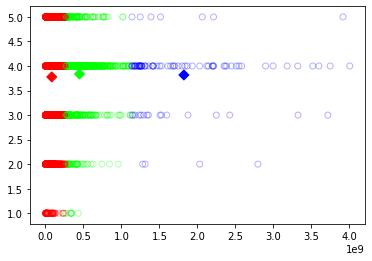

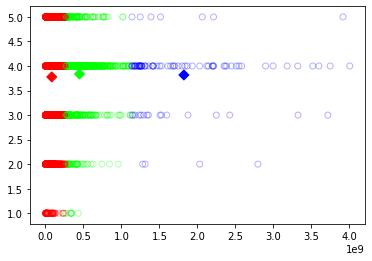

In [20]:
runKMeans(3, df_games, ["Size", "Average User Rating"]) 

In [21]:
best_kvalue = calculate_WSS(df_games, ["User Rating Count", "Average User Rating"],10)

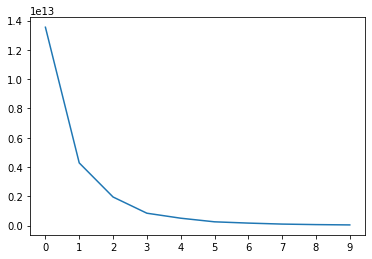

In [22]:
# Best K-value is at the "elbow" in the curve, in this case we choose 3
plt.xticks(np.arange(10))
plt.plot(best_kvalue)

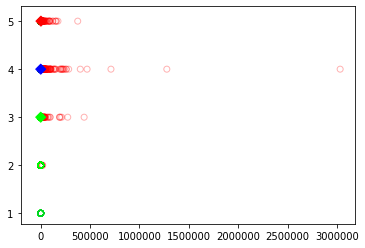

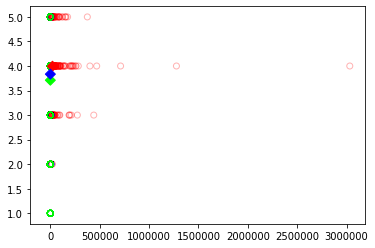

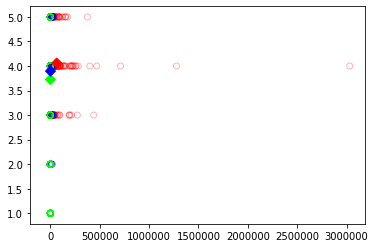

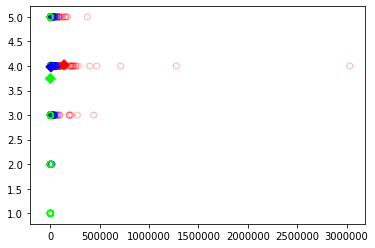

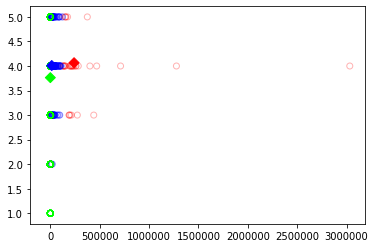

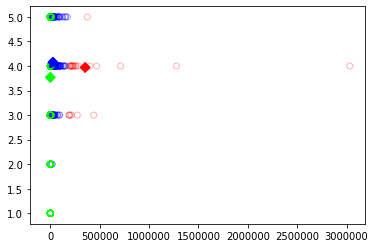

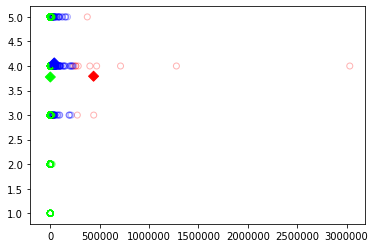

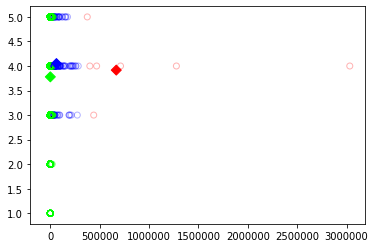

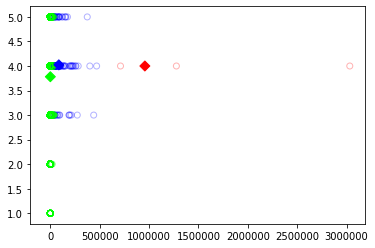

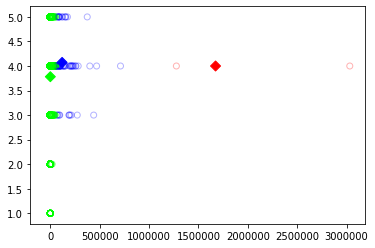

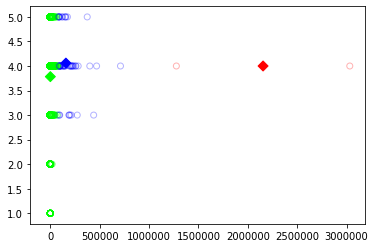

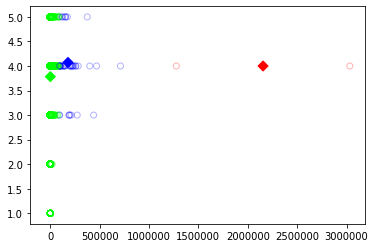

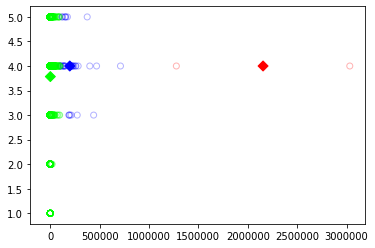

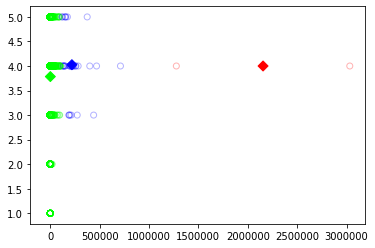

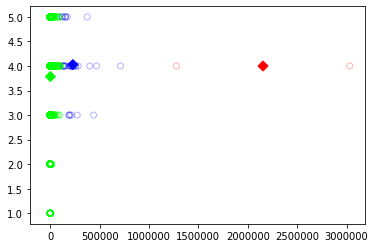

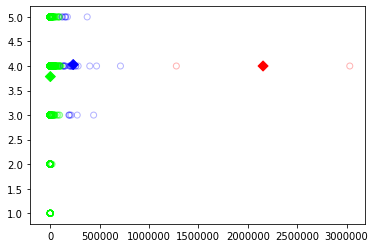

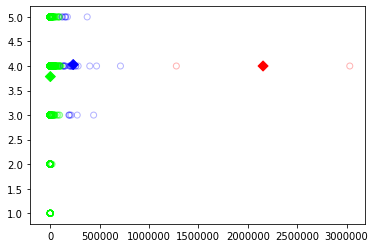

In [23]:
runKMeans(3, df_games, ["User Rating Count", "Average User Rating"])

# Classification Using Logistic Regression

Finding the relationship between variables and average user rating, by using logistic regression and binary classification (category 0 for average user rating of 3.0 or under, category 1 for average user rating of 3.5 or above).

In [24]:
df_games_clf = df_games

In [25]:
#create numerical labels for categorical variable (genres)
le = preprocessing.LabelEncoder()
le.fit(df_games_clf['Genres'])
df_games_clf['Genres'] = le.transform(df_games_clf['Genres']) 

In [26]:
df_games_clf['Average User Rating'] = np.where(df_games_clf['Average User Rating']>3.0, 1, 0)
df_games_clf['Average User Rating'].value_counts()

1    6498
0    1063
Name: Average User Rating, dtype: int64

In [27]:
#split into X (all other variables except average user rating) and Y (average user rating)
X = df_games_clf[['User Rating Count', 'Price', 'In-app Purchases', 'Age Rating', 'Size', 'Genres']]
Y = df_games_clf[['Average User Rating']]

#convert to numpy array
X = X.to_numpy()
Y = Y.to_numpy()

In [28]:
#split into train-test 80-20 %
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

In [29]:
#perfrom logistic regression
LR = LogisticRegression(solver='lbfgs', multi_class='ovr').fit(x_train, y_train.ravel())

#predict values on test dataset
LR.predict(x_test)

#get accuracy and round to 4 decimal points
print("Accuracy:", round(LR.score(x_test,y_test.ravel()), 4))
print("F1 score", f1_score(LR.predict(x_test), y_test))

Accuracy: 0.8562
F1 score 0.9225071225071224


# Classification Using SVM

Finding the relationship between variables and average user rating, by using SVM and binary classification (category 0 for average user rating of 3.0 or under, category 1 for average user rating of 3.5 or above).

In [30]:
#radial basis function kernel
SVM = svm.SVC(kernel='rbf', gamma='auto')
SVM.fit(x_train, y_train.ravel())
SVM.predict(x_test)
print("Accuracy", round(SVM.score(x_test,y_test.ravel()), 4))
print("F1 score", f1_score(SVM.predict(x_test), y_test))

Accuracy 0.8583
F1 score 0.9235159817351598


In [31]:
#linear kernel
SVM2 = svm.LinearSVC()
SVM2.fit(x_train, y_train.ravel())
SVM2.predict(x_test)
print("Accuracy", round(SVM2.score(x_test,y_test.ravel()), 4))
print("F1 score", f1_score(SVM2.predict(x_test), y_test))

Accuracy 0.1438
F1 score 0.0


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


# Classification Using Random Forest


In [47]:
def runRandomForest(X_train, Y_train, X_test, Y_test):
    D_list = np.array([1,2,3,4,5,6,7,8,9,10])
    parameters = {'max_depth':D_list}
    clf = RandomForestClassifier(criterion = "entropy", n_estimators = 1024)
    grid_search = GridSearchCV(clf,parameters,cv= 5, return_train_score = True, n_jobs=-1)
    grid_search.fit(X_train,Y_train)
    
    #plot heatmaps
    train_acc = (grid_search.cv_results_['mean_train_score']).reshape(-1,1)
    
    val_acc = (grid_search.cv_results_['mean_test_score']).reshape(-1,1)
    
    #predict with best parameter
    best_D = grid_search.best_params_['max_depth']
    new_clf = RandomForestClassifier(max_depth = best_D, criterion="entropy",n_estimators=10)
    new_clf.fit(X_train,Y_train)
    
    test_acc = new_clf.score(X_test,Y_test)
    
    return test_acc, best_D

In [48]:
runRandomForest(x_train,y_train,x_test,y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


(0.8566895822316235, 7)